### Importing

In [1]:
import os
import glob
import pandas as pd
import numpy as np
np.random.seed(42)
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import multivariate_normal
import scipy.stats as stats
import scipy
import math
from scipy.spatial import Voronoi, voronoi_plot_2d

### Data Importing

In [2]:
# Specify the relative path to the data directory
#data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Data"
non_games_data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Non_Games_Data"

# List all files in the data folder
#file_list = os.listdir(data_folder_path)
file_list_non_games = os.listdir(non_games_data_folder_path)

# Use glob to filter specific file types
#csv_files = glob.glob(os.path.join(data_folder_path, "*.csv"))
csv_files_non_games = glob.glob(os.path.join(non_games_data_folder_path, "*.csv"))

# Read in the weekly game data and concat into one combined df
#dfs = [pd.read_csv(file) for file in csv_files]
#combined_df = pd.concat(dfs, ignore_index=True)

# Read in the supplementary data
games = pd.read_csv(csv_files_non_games[0])
nfl_colors = pd.read_csv(csv_files_non_games[1])
players = pd.read_csv(csv_files_non_games[2])
plays = pd.read_csv(csv_files_non_games[3])
tackles = pd.read_csv(csv_files_non_games[4])

### ModelingDF

In [3]:
ModelingDF = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/WorkDF.csv")

C:\Users\sethl\AppData\Local\Temp\ipykernel_19132\1690626378.py:1: DtypeWarning: Columns (45,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  ModelingDF = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/WorkDF.csv")


### Voronoi Tesselations

In [ ]:

def custom_scaling_factor(value):
    if value == 0:
        return 0
    elif 1 <= value <= 6:
        return np.exp(value - 6)
    elif value > 6:
        return np.log(value + 1) / np.log(6)

def count_matching_rows(df):
    counts = []
    target = 7.5

    for index, row in df.iterrows():
        if row["distanceFromBall"] <= target:
            counts.append(1)
        else:
            counts.append(0)
    return sum(counts) 

def Calculate_Gravity(playerCoordinates = []):    
    
    playerCoordinates["UniqueIndex"] = playerCoordinates["gameId"].astype(str) + "-" + playerCoordinates['playId'].astype(str) + "-" + playerCoordinates['frameId'].astype(str)

    TotalGravity = pd.DataFrame()

    unique_frames = playerCoordinates['UniqueIndex'].unique()

    output_df = pd.DataFrame()

    for frame in unique_frames:

        frame_data = playerCoordinates[playerCoordinates["UniqueIndex"] == frame]

        frame_data = frame_data[(frame_data["club"] == frame_data['defensiveTeam']) |
                                            (frame_data["GotTheBall"] == 1)]
        
        frame_data.sort_values(by=['gameId', 'playId', 'nflId', 'frameId'], inplace=True)
        
        xCoordinateBall=frame_data.loc[(frame_data["GotTheBall"] == 1)]['x'].unique()[0]
        yCoordinateBall=frame_data.loc[(frame_data["GotTheBall"] == 1)]['y'].unique()[0]
        frame_data['distanceFromBall']=((frame_data['x']-xCoordinateBall)**2 + \
                                         (frame_data['y']-yCoordinateBall)**2)**(1/2)
        

        bounding_lowerL = {'x' : min(frame_data['x'].min() - 1, 0),
                            'y' : min(frame_data['y'].min() - 1, 0)} 
        bounding_upperL = {'x' : max(frame_data['x'].max() + 1, 120),
                            'y' : max(frame_data['y'].max() + 1, 53.3)}
        bounding_lowerR = {'x' : min(frame_data['x'].min() - 1, 0),
                            'y' : max(frame_data['y'].max() + 1, 53.3)}
        bounding_upperR = {'x' : max(frame_data['x'].max() + 1, 120),
                            'y' : min(frame_data['y'].min() - 1, 0)}

        bounding_lowerL = pd.DataFrame([bounding_lowerL])
        bounding_upperL = pd.DataFrame([bounding_upperL])
        bounding_lowerR = pd.DataFrame([bounding_lowerR])
        bounding_upperR = pd.DataFrame([bounding_upperR])


        frame_data = pd.concat([frame_data, bounding_lowerL], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_upperL], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_lowerR], ignore_index=True)
        frame_data = pd.concat([frame_data, bounding_upperR], ignore_index=True)

        frame_data["DefendersWithin"] = count_matching_rows(frame_data)

        points = frame_data[['x', 'y']].dropna().values

        # Create a Voronoi diagram
        vor = Voronoi(points)

        # Iterate through the input points
        for i, point in enumerate(points):
            # Find the Voronoi region index for the current point
            region_index = vor.point_region[i]
            
            # Get the vertices of the region
            region_vertices = vor.regions[region_index]
            
            # Filter out invalid vertices
            region_vertices = [vertex for vertex in region_vertices if vertex != -1]
            
            if len(region_vertices) > 0:
                # Get the vertices of the region
                vertices = vor.vertices[region_vertices]
                
                # Calculate the area using the Shoelace formula
                area = 0.5 * np.abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) -
                                np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))
                
                # Store the area in the 'area' column of VOR_df for the current point
                frame_data.at[i, 'area'] = area

            closest_frame_df = frame_data[(frame_data["distanceFromBall"] <= 10) &
                                 (frame_data["club"] == frame_data["defensiveTeam"])][["gameId", "playId", "frameId", "nflId"]]


        TotalGravity = pd.concat([TotalGravity, frame_data], ignore_index=True) 

        TotalGravity.dropna(subset = ["gameId"], inplace = True)

        output_df = pd.concat([output_df, closest_frame_df], ignore_index=True) 


        TotalGravity = TotalGravity[TotalGravity["GotTheBall"] == 1]

        TotalGravity["ScalingFactor"] = TotalGravity["DefendersWithin"].apply(custom_scaling_factor)

        TotalGravity['adjusted_change'] = TotalGravity['area'] * TotalGravity["PercentRankA"] * \
                                            TotalGravity["ScalingFactor"]

    return (TotalGravity, output_df)

WorkDF_data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/WorkDF"

# List all files in the data folder
WorkDF_file_list = os.listdir(WorkDF_data_folder_path)

# Use glob to filter specific file types
WorkDF_csv_files = glob.glob(os.path.join(WorkDF_data_folder_path, "*.csv"))


for game in WorkDF_csv_files:
    # Your code to process the chunk
    VOR_df = pd.read_csv(game)

    gameName = VOR_df["gameId"].unique()

    VOR_df_output, closest_df = Calculate_Gravity(VOR_df)    

    vor_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/VoronoiChunks/"

    vor_filename = f"VoronoiChunk{gameName}.csv"
    
    # Save the processed chunk to a specific location
    VOR_df_output.to_csv(f"{vor_filepath}{vor_filename}", index=False)

    
    closest_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/ClosestChunks/"

    closest_filename = f"ClosestChunk{gameName}.csv"
    
    # Save the processed chunk to a specific location
    closest_df.to_csv(f"{closest_filepath}{closest_filename}", index=False)

    del VOR_df


In [ ]:
vor_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/VoronoiChunks"

# List all files in the data folder
vor_file_list = os.listdir(vor_filepath)

# Use glob to filter specific file types
vor_csv_files = glob.glob(os.path.join(vor_filepath, "*.csv"))

# Read in the weekly game data and concat into one combined df
vor_dfs = [pd.read_csv(file) for file in vor_csv_files]
VOR_df_output = pd.concat(vor_dfs, ignore_index=True)


In [ ]:
print(VOR_df_output["distanceFromBall"].mean())
print(VOR_df_output["area"].mean())
print(VOR_df_output["adjusted_change"].mean())
print(VOR_df_output["DefendersWithin"].mean())

In [ ]:
Min_Play_Count = 15

ExtraWork = VOR_df_output.copy()

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = ExtraWork.groupby('nflId')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
ExtraWork['TotalPlays'] = ExtraWork['nflId'].map(play_counts)
ExtraWork = ExtraWork[ExtraWork["TotalPlays"] >= Min_Play_Count]

Summarized = pd.DataFrame()
Summarized["MeanPlay"] = ExtraWork.groupby(["nflId"])["adjusted_change"].mean()
Summarized["MeanDefenders"] = ExtraWork.groupby(["nflId"])["DefendersWithin"].mean()
Summarized = Summarized.drop_duplicates()
Summarized.reset_index(inplace=True)

Summarized = Summarized.sort_values(by=['MeanPlay'], ascending = False)

player_name = players[["nflId", "position", "displayName"]]

Summarized = pd.merge(Summarized, player_name, on = "nflId")

TotalPlays = ExtraWork[["nflId", "club", "TotalPlays"]].drop_duplicates()

Summarized = pd.merge(Summarized, TotalPlays, on = "nflId")
Summarized = Summarized.drop_duplicates()

EPA = plays.groupby(["ballCarrierId"])["expectedPointsAdded"].mean()

Summarized = pd.merge(Summarized, EPA, left_on="nflId", right_on="ballCarrierId")

Summarized = Summarized.drop_duplicates()


In [ ]:
VOR_df_output.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv", index=False)
Summarized.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYACSummarized.csv", index=False)


### Defensive Closest Gravity

In [ ]:
closest_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/ClosestChunks"

# List all files in the data folder
closest_file_list = os.listdir(closest_filepath)

# Use glob to filter specific file types
closest_csv_files = glob.glob(os.path.join(closest_filepath, "*.csv"))

# Read in the weekly game data and concat into one combined df
closest_dfs = [pd.read_csv(file) for file in closest_csv_files]
closest_df = pd.concat(closest_dfs, ignore_index=True)

VOR_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv")


In [ ]:

ClosestPlayersWork = pd.merge(VOR_df_output, closest_df, on = ["gameId", "playId", "frameId"])

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = ClosestPlayersWork.groupby('nflId_y')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
ClosestPlayersWork['TotalPlays'] = ClosestPlayersWork['nflId_y'].map(play_counts)
ClosestPlayersWork = ClosestPlayersWork[ClosestPlayersWork["TotalPlays"] >= 15]


ClosestSummary = pd.DataFrame()

ClosestSummary["PassVoronoi"] = ClosestPlayersWork[ClosestPlayersWork["PassPlay"] == 1].groupby('nflId_y')["adjusted_change"].mean()

ClosestSummary["RushVoronoi"] = ClosestPlayersWork[ClosestPlayersWork["PassPlay"] == 0].groupby('nflId_y')["adjusted_change"].mean()

ClosestSummary["TotalVoronoi"] = ClosestPlayersWork.groupby('nflId_y')["adjusted_change"].mean()

#ClosestSummary = ClosestSummary[ClosestSummary["RushVoronoi"] >= 0]


ClosestSummary = ClosestSummary.drop_duplicates()
ClosestSummary.reset_index(inplace=True)
TotalPlaysClosest = ClosestPlayersWork[["nflId_y", "defensiveTeam", "TotalPlays"]].drop_duplicates()

ClosestSummary = pd.merge(ClosestSummary, TotalPlaysClosest, on = "nflId_y")

ClosestSummary = pd.merge(ClosestSummary, player_name, left_on = "nflId_y", right_on = "nflId")

PlayerSingleName = players[["nflId", "displayName"]].drop_duplicates()

#ClosestSummary = ClosestSummary.drop_duplicates(subset = "nflId")
ClosestSummary = pd.merge(ClosestSummary, PlayerSingleName, left_on = "nflId_y", right_on = "nflId")

ClosestSummary = ClosestSummary.rename(columns={'nflId_y': 'nflId'})
ClosestSummary = ClosestSummary[["nflId", 'displayName', 'position',
                                  'displayName', 'defensiveTeam',
                                 'TotalPlays',
                                 "PassVoronoi", 'RushVoronoi', 'TotalVoronoi']]
ClosestSummary = ClosestSummary.sort_values(by=['TotalVoronoi'], ascending = True)

In [ ]:
closest_df.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDefenseClosest.csv", index=False)
ClosestSummary.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDefenseClosestSummary.csv", index=False)


### Team Gravity 

In [ ]:
VOR_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv")


In [ ]:

DefensiveGravityWork = VOR_df_output.copy()

#player_name = players[["nflId", "position", "displayName"]]
#DefensiveGravityWork = pd.merge(DefensiveGravityWork, player_name, on = "nflId")
#DefensiveGravityWork = DefensiveGravityWork[DefensiveGravityWork["position"] != "QB"]

DefensiveGravity = pd.DataFrame()
DefensiveGravity["PassVoroni"] = DefensiveGravityWork[DefensiveGravityWork["PassPlay"] == 1].groupby("defensiveTeam")["adjusted_change"].mean()
DefensiveGravity["RushVoronoi"] = DefensiveGravityWork[DefensiveGravityWork["PassPlay"] == 0].groupby("defensiveTeam")["adjusted_change"].mean()
DefensiveGravity["TotalVoronoi"] = DefensiveGravityWork.groupby("defensiveTeam")["adjusted_change"].mean()
DefensiveGravity = DefensiveGravity.drop_duplicates()
DefensiveGravity.reset_index(inplace=True)

DefensiveGravity = DefensiveGravity.sort_values(by=['TotalVoronoi'], ascending = True)



'''
OffensiveGravity = pd.DataFrame()
OffensiveGravity["MeanPlayO"] = DefensiveGravityWork.groupby(["possessionTeam"])["adjusted_change"].mean()
OffensiveGravity = OffensiveGravity.drop_duplicates()
OffensiveGravity.reset_index(inplace=True)

OffensiveGravity = OffensiveGravity.sort_values(by=['MeanPlayO'], ascending = False)

'''

In [ ]:
#OffensiveGravity.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/OffensiveGravityTeam.csv", index=False)
DefensiveGravity.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/DefensiveGravityTeam.csv", index=False)


### Break Through

In [ ]:
def find_rows_above_threshold(array, threshold=1e-3):
    max_values = np.amax(array, axis=1)  # Get maximum values for each row
    above_threshold = max_values > threshold
    first_index = np.argmax(above_threshold)
    last_index = len(above_threshold) - np.argmax(above_threshold[::-1]) - 1
    return first_index.astype(int), last_index.astype(int)

def find_columns_above_threshold(array, threshold=1e-3):
    max_values = np.amax(array, axis=0)  # Get maximum values for each column
    above_threshold = max_values > threshold
    first_index = np.argmax(above_threshold)
    last_index = len(above_threshold) - np.argmax(above_threshold[::-1]) - 1
    return first_index.astype(int), last_index.astype(int)

def uncovered_frame_list(row):
    Ball_min_y = row["Ball_Min_y"]
    Ball_Max_y = row["Ball_Max_y"]
    Player_Min_y = row["Min_y"]
    Player_Max_y = row["Max_y"]
    
    Ball_min_x = row["Ball_Min_x"]
    Ball_Max_x = row["Ball_Max_x"]
    Player_Min_x = row["Min_x"]
    Player_Max_x = row["Max_x"]

    Ball_Carrier = row['GotTheBall']
    
    condition = np.all((Player_Min_y <= Ball_min_y) & \
                        (Player_Max_y >= Ball_Max_y) & \
                          (Player_Max_x >=  Ball_Max_x) & \
                            (Ball_Carrier != 1))
    
    return 1 if condition else 0

def CalculateBreakthrough(playerCoordinates=[]):

  np.random.seed(42)
  
  #Determined each speed in x and y, as well as distance from the QB
  # Filter rows where 'GotTheBall' is 1
  ball_data = playerCoordinates[playerCoordinates["GotTheBall"] == 1]

  # Calculate x and y coordinates of the ball for each play and frame
  ball_data = ball_data.groupby(["playId", "frameId"]).agg({'clean_x': 'unique', 'clean_y': 'unique'}).reset_index()

  # Merge these coordinates back into the original DataFrame
  playerCoordinates = playerCoordinates.merge(ball_data, on=["playId", "frameId"], suffixes=('', '_Ball'), how='left')

  # Calculate the distance from the ball
  playerCoordinates['distanceFromBall'] = (
      (playerCoordinates['clean_x'] - playerCoordinates['clean_x_Ball'])**2 +
      (playerCoordinates['clean_y'] - playerCoordinates['clean_y_Ball'])**2
  )**(1/2)
  
  playerCoordinates['distanceFromBall'] = np.where(playerCoordinates['distanceFromBall'] == 0, 1.5, playerCoordinates['distanceFromBall']).astype(float)

  playerCoordinates['PartOfPlay'] = playerCoordinates.groupby(['playId','nflId'])['distanceFromBall'].transform(lambda x: (x <= 10).any()).astype(int)
  
  playerCoordinates['radiansDirection'] = playerCoordinates['clean_dir'].astype(float).apply(math.radians) #Converts angle in degrees to radians
  playerCoordinates['xComponent']=playerCoordinates['radiansDirection'].astype(float).apply(math.cos) #Converts angle into an x and y component
  playerCoordinates['yComponent']=playerCoordinates['radiansDirection'].astype(float).apply(math.sin)
  playerCoordinates['xspeed']=playerCoordinates['xComponent']*playerCoordinates['s'] #Determines magnitude of speed by multiplying x and y component by magnitude of speed
  playerCoordinates['yspeed']=playerCoordinates['yComponent']*playerCoordinates['s']
  playerCoordinates['xComponent']= np.where((playerCoordinates['xComponent'] < 1e-2) & 
                                            (playerCoordinates['xComponent'] > -1e-2), 1e-2, playerCoordinates['xComponent'])
  playerCoordinates['yComponent']= np.where((playerCoordinates['yComponent'] < 1e-2) & 
                                            (playerCoordinates['yComponent'] > -1e-2), 1e-2, playerCoordinates['yComponent'])


  
  playerCoordinates["UniqueIndex"] = playerCoordinates["gameId"].astype(str) + "-" + playerCoordinates['playId'].astype(str) + "-" + playerCoordinates['frameId'].astype(str)

  unique_frames = playerCoordinates['UniqueIndex'].unique()

  output_df = pd.DataFrame()
  
  y, x = np.mgrid[0:53.3:1, 0:120:1]
  locations = np.dstack((x, y))
  
  for frame in unique_frames:

    frame_data = playerCoordinates[playerCoordinates["UniqueIndex"] == frame]
    frame_list = []

    frame_data = frame_data[((frame_data["PartOfPlay"] == 1) & (frame_data["club"] == frame_data["defensiveTeam"])) |  
                                        (frame_data["GotTheBall"] == 1)]

    # Generate pdf's for the defensive players and the quarteback
    for index, row in frame_data.iterrows():
      if((row['club'] == row['defensiveTeam'])) | (row["GotTheBall"] == 1):
        speed_Ratio=(row['s']**2)/(100)
        topLeftSMatrix=(row['distanceFromBall']+row['distanceFromBall']*speed_Ratio)/2
        bottomRightSMatrix=(row['distanceFromBall']-row['distanceFromBall']*speed_Ratio)/2

        try:
          #Setting up R and S matrix in bivariate normal distribution
          r_matrix=[(row['xComponent'], -row['yComponent']),(row['yComponent'], row['xComponent'])]
          r_matrix=pd.DataFrame(data=r_matrix)
          #Adds very small value to ensure matrix is invertible even if player is completely stationary
          s_matrix=[(topLeftSMatrix+0.00001,0), (0, bottomRightSMatrix-0.000001)]
          s_matrix=pd.DataFrame(data=s_matrix)
          inverse_r_Matrix=np.linalg.inv(r_matrix)
          multiplyingTogetherFirstTwoMatrices=r_matrix.dot(s_matrix)
          nextMatrix=multiplyingTogetherFirstTwoMatrices.dot(s_matrix)
          covariance_matrix=nextMatrix.dot(inverse_r_Matrix)
          mu_val_x=row['clean_x']+row['xspeed']*0.5
          mu_val_y=row['clean_y']+row['yspeed']*0.5
          mu=[mu_val_x,mu_val_y]
          player_pdf=multivariate_normal(mu,covariance_matrix).pdf(locations)

          Player_y_max = find_rows_above_threshold(player_pdf)

          Player_x_max = find_columns_above_threshold(player_pdf)

          frame_data.at[index, "Max_y"] = int(Player_y_max[1])
          frame_data.at[index, "Min_y"] = int(Player_y_max[0])

          frame_data.at[index, "Max_x"] = int(Player_x_max[1])
          frame_data.at[index, "Min_x"] = int(Player_x_max[0])

          frame_data["Max_y"] = frame_data["Max_y"].fillna(0)
          frame_data["Min_y"] = frame_data["Min_y"].fillna(53) 

          frame_data["Max_x"] = frame_data["Max_x"].fillna(0)
          frame_data["Min_x"] = frame_data["Min_x"].fillna(120) 

          
        except np.linalg.LinAlgError:
           pass

    frame_data["Ball_Max_y"] = frame_data.loc[frame_data["GotTheBall"] == 1, "Max_y"].iloc[0].astype(int)
    frame_data["Ball_Min_y"] = frame_data.loc[frame_data["GotTheBall"] == 1, "Min_y"].iloc[0].astype(int)
    
    frame_data["Ball_Max_x"] = frame_data.loc[frame_data["GotTheBall"] == 1, "Max_x"].iloc[0].astype(int)
    frame_data["Ball_Min_x"] = frame_data.loc[frame_data["GotTheBall"] == 1, "Min_x"].iloc[0].astype(int)

    frame_data["Covering"] = frame_data.apply(uncovered_frame_list, axis=1)

    output_df = pd.concat([output_df, frame_data], ignore_index=True)

  
  return output_df
      




In [ ]:
WorkDF_data_folder_path = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/WorkDF"

# List all files in the data folder
WorkDF_file_list = os.listdir(WorkDF_data_folder_path)

# Use glob to filter specific file types
WorkDF_csv_files = glob.glob(os.path.join(WorkDF_data_folder_path, "*.csv"))


for game in WorkDF_csv_files:

    #Write code chunk to check if any of the files already in the folder are named what we want
    #if so ignore it and move on to the next one


    # Your code to process the chunk
    breakthrough_df = pd.read_csv(game)

    gameName = breakthrough_df["gameId"].unique()

    # Your code to process the chunk
    breakthrough_df = CalculateBreakthrough(breakthrough_df)    

    filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/BreakThroughChunks/"

    filename = f"BreakThroughChunk{gameName}.csv"
    
    # Save the processed chunk to a specific location
    breakthrough_df.to_csv(f"{filepath}{filename}", index=False)

    del breakthrough_df

In [ ]:
breakthrough_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/BreakThroughChunks"

# List all files in the data folder
BreakThrough_file_list = os.listdir(breakthrough_filepath)

# Use glob to filter specific file types
BreakThrough_csv_files = glob.glob(os.path.join(breakthrough_filepath, "*.csv"))

#Breakthrough_df_output = pd.read_csv(BreakThrough_csv_files[0])

# Read in the weekly game data and concat into one combined df
BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
BreakThrough_df_output = pd.concat(BreakThrough_dfs, ignore_index=True)

In [ ]:
Break_work = BreakThrough_df_output[["gameId", "playId", "frameId", 'PassPlay',
                                     "club", "possessionTeam", "defensiveTeam",
                                       "GotTheBall", "nflId", "displayName", "Covering"]]

player_name = players[["nflId", "position"]]
BreakThrough = Break_work.groupby(["gameId", "playId", "frameId"])["Covering"].sum()

BreakThrough = pd.merge(Break_work, BreakThrough, on = ["gameId", "playId", "frameId"])

BreakThrough["BreakThrough"] = np.where(BreakThrough["Covering_y"] == 0, 1, 0)

BreakThrough = BreakThrough[(BreakThrough["club"] == BreakThrough["defensiveTeam"])]

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = BreakThrough.groupby('nflId')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
BreakThrough['TotalPlays'] = BreakThrough['nflId'].map(play_counts)
BreakThrough = BreakThrough[BreakThrough["TotalPlays"] >= 15]
TotalPlays = BreakThrough[["nflId","TotalPlays"]].drop_duplicates()

TeamNameJoin = BreakThrough[['club', "nflId", "displayName"]].drop_duplicates()


Summarized_BreakThrough = pd.DataFrame()
Summarized_BreakThrough["PassShielding"] = BreakThrough[BreakThrough["PassPlay"] == 1].groupby("nflId")["Covering_x"].mean()
Summarized_BreakThrough["RushShielding"] = BreakThrough[BreakThrough["PassPlay"] == 0].groupby("nflId")["Covering_x"].mean()
Summarized_BreakThrough["TotalShielding"] = BreakThrough.groupby("nflId")["Covering_x"].mean()
Summarized_BreakThrough = pd.merge(Summarized_BreakThrough, TotalPlays, on = "nflId")
Summarized_BreakThrough = pd.merge(Summarized_BreakThrough, TeamNameJoin, on = "nflId")
Summarized_BreakThrough = pd.merge(Summarized_BreakThrough, player_name, on = "nflId")






In [ ]:
#BreakThrough_df_output.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthrough.csv", index=False)
Summarized_BreakThrough.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthroughSummarized.csv", index=False)


### Team BreakThrough Perc

In [ ]:
BreakThrough_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthrough.csv")


In [ ]:
Break_work = BreakThrough_df_output[["gameId", "playId", "frameId", 'PassPlay', "club", "possessionTeam", "defensiveTeam", "GotTheBall", "nflId", "displayName", "Covering"]]
player_name = players[["nflId", "position"]]
BreakThrough = Break_work.groupby(["gameId", "playId", "frameId"])["Covering"].sum()

BreakThrough = pd.merge(Break_work, BreakThrough, on = ["gameId", "playId", "frameId"])

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = BreakThrough.groupby('nflId')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
BreakThrough['TotalPlays'] = BreakThrough['nflId'].map(play_counts)
BreakThrough = BreakThrough[BreakThrough["TotalPlays"] >= 15]

BreakThrough["BreakThrough"] = np.where(BreakThrough["Covering_y"] == 0, 1, 0)


DefensiveBreakThrough = pd.DataFrame()
DefensiveBreakThrough["PassShielding"] = BreakThrough[BreakThrough["PassPlay"] == 1].groupby("defensiveTeam")["Covering_x"].mean()
DefensiveBreakThrough["RushShielding"] = BreakThrough[BreakThrough["PassPlay"] == 0].groupby("defensiveTeam")["Covering_x"].mean()
DefensiveBreakThrough["TotalShielding"] = BreakThrough.groupby("defensiveTeam")["Covering_x"].mean()
DefensiveBreakThrough = DefensiveBreakThrough.drop_duplicates()
DefensiveBreakThrough.reset_index(inplace=True)

DefensiveBreakThrough = DefensiveBreakThrough.sort_values(by=['TotalShielding'], ascending = False)


'''
OffensiveBreakThrough = pd.DataFrame()
OffensiveBreakThrough["BreakThroughO"] = BreakThrough.groupby(["possessionTeam"])["BreakThrough"].mean()
OffensiveBreakThrough = OffensiveBreakThrough.drop_duplicates()
OffensiveBreakThrough.reset_index(inplace=True)

OffensiveBreakThrough = OffensiveBreakThrough.sort_values(by=['BreakThroughO'], ascending = False)

'''

In [ ]:
#OffensiveBreakThrough.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/OffensiveBreakThroughTeam.csv", index=False)
DefensiveBreakThrough.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/DefensiveBreakThroughTeam.csv", index=False)


### Deviation from Ideal Angles

In [ ]:
BreakThrough_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthrough.csv")

In [ ]:
def calculate_angle(row):
    Expected_x = (row["Ball_Max_x"] + row['Ball_Min_x']) / 2
    Expected_y = (row["Ball_Max_y"] + row['Ball_Min_y']) / 2
    delta_x = Expected_x - row['clean_x']
    delta_y = Expected_y - row['clean_y']
    angle_radians = math.atan2(delta_y, delta_x)
    angle_radians = np.where(angle_radians < 0, angle_radians + 2 * math.pi, angle_radians) 
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def Calculate_Deviation_From_Ideal(row):
    Deviation = abs(row["clean_dir"] - row["IdealAngle"]) ** 2
    return Deviation

In [ ]:
Deviation = BreakThrough_df_output.copy()

Deviation["IdealAngle"] = Deviation.apply(calculate_angle, axis = 1)

Deviation["Deviation"] = Deviation.apply(Calculate_Deviation_From_Ideal, axis = 1)

In [ ]:
DeviationWork = Deviation[["gameId", "playId", "frameId", 'PassPlay', "club", "possessionTeam", "defensiveTeam", "GotTheBall", "nflId",\
                            "displayName", 'distanceFromBall',"clean_dir", "IdealAngle",
                              "Deviation"]]


player_name = players[["nflId", "position"]]

DeviationWork = DeviationWork[(DeviationWork["club"] == DeviationWork["defensiveTeam"])]

# Group by 'nflId' and count the unique 'frameId' values in each group
play_counts = DeviationWork.groupby('nflId')['playId'].nunique()

# Create a new column 'TotalPlays' in the original DataFrame
DeviationWork['TotalPlays'] = DeviationWork['nflId'].map(play_counts)
TotalPlays = DeviationWork[["nflId","TotalPlays"]].drop_duplicates()

TeamNameJoin = DeviationWork[['club', "nflId", "displayName"]].drop_duplicates()



DeviationSummary = pd.DataFrame()
DeviationSummary["PassMeanSquaredDeviation"] = DeviationWork[DeviationWork["PassPlay"] == 1].groupby("nflId")["Deviation"].mean()
DeviationSummary["PassRootMeanSquaredDeviation"] = np.sqrt(DeviationSummary["PassMeanSquaredDeviation"])
DeviationSummary["RushMeanSquaredDeviation"] = DeviationWork[DeviationWork["PassPlay"] == 0].groupby("nflId")["Deviation"].mean()
DeviationSummary["RushRootMeanSquaredDeviation"] = np.sqrt(DeviationSummary["RushMeanSquaredDeviation"])
DeviationSummary["TotalMeanSquaredDeviation"] = DeviationWork.groupby("nflId")["Deviation"].mean()
DeviationSummary["TotalRootMeanSquaredDeviation"] = np.sqrt(DeviationSummary["TotalMeanSquaredDeviation"])
DeviationSummary = pd.merge(DeviationSummary, TotalPlays, on = "nflId")
DeviationSummary = pd.merge(DeviationSummary, TeamNameJoin, on = "nflId")
DeviationSummary = pd.merge(DeviationSummary, player_name, on = "nflId")


In [ ]:
Deviation.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviation.csv", index=False)
DeviationSummary.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviationSummarized.csv", index=False)


### Team Deviation

In [ ]:
Deviation = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviation.csv", index=False)


In [ ]:
DeviationWork = DeviationWork[DeviationWork["TotalPlays"] >= 15]


TeamDeviation = pd.DataFrame()
TeamDeviation["PassMeanSquaredDeviation"] = DeviationWork[DeviationWork["PassPlay"] == 1].groupby("club")["Deviation"].mean()
TeamDeviation["PassRootMeanSquaredDeviation"] = np.sqrt(TeamDeviation["PassMeanSquaredDeviation"])
TeamDeviation["RushMeanSquaredDeviation"] = DeviationWork[DeviationWork["PassPlay"] == 0].groupby("club")["Deviation"].mean()
TeamDeviation["RushRootMeanSquaredDeviation"] = np.sqrt(TeamDeviation["RushMeanSquaredDeviation"])
TeamDeviation["TotalMeanSquaredDeviation"] = DeviationWork.groupby("club")["Deviation"].mean()
TeamDeviation["TotalRootMeanSquaredDeviation"] = np.sqrt(TeamDeviation["TotalMeanSquaredDeviation"])
TeamDeviation = TeamDeviation.drop_duplicates()
TeamDeviation.reset_index(inplace=True)

TeamDeviation = TeamDeviation.sort_values(by=['TotalRootMeanSquaredDeviation'], ascending = True)


In [ ]:
TeamDeviation.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/TeamDeviation.csv", index=False)


## Full Enchilada

In [3]:
#YACSummarized = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYACSummarized.csv")
BreakthroughSummarized = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthroughSummarized.csv")
ClosestSummary = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDefenseClosestSummary.csv")
DeviationSummary = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviationSummarized.csv")


In [ ]:
Full_Offense = pd.merge(YACSummarized, BreakthroughSummarized, on = ["nflId", "displayName", "club", "position"])

Full_Offense = Full_Offense[Full_Offense["TotalPlays_x"] >= 15]

# Calculate percent ranks within each position group
Full_Offense['PercentRankGravity'] = Full_Offense.groupby('position')['MeanPlay'].transform(
    lambda x: (x.abs() / x.abs().max())
)

Full_Offense['PercentRankBreakthrough'] = Full_Offense.groupby('position')['UnCoveredPerc'].transform(
    lambda x: (x.abs() / x.abs().max())
)

Full_Offense["KEEPAWAY"] = (Full_Offense["PercentRankBreakthrough"] + Full_Offense["PercentRankGravity"] * 2) / 3

Full_Offense = Full_Offense[["displayName", "nflId", "position", "club", "TotalPlays_x", "MeanPlay", "UnCoveredPerc", "expectedPointsAdded", 
                             "PercentRankGravity", "PercentRankBreakthrough", "KEEPAWAY"]]


Full_Offense = Full_Offense.sort_values(by=['KEEPAWAY'], ascending = False)

In [4]:
AltPositionNames = {
    "DT" : "DT",
    "NT" : "DT",
    "MLB" : "LB",
    "ILB" : "LB",
    "DE" : "ED",
    "OLB" : "ED",
    "CB" : "CB",
    "SS" : "S",
    "FS" : "S",
    "DB" : "LB",
}

AltPositionGroups = {
    "DT" : "DL",
    "NT" : "DL",
    "MLB" : "LB",
    "ILB" : "LB",
    "DE" : "DL",
    "OLB" : "DL",
    "CB" : "DB",
    "SS" : "DB",
    "FS" : "DB",
    "DB" : "LB",
}

In [6]:
Full_Defense = pd.merge(ClosestSummary, BreakthroughSummarized, on = ["nflId", "displayName", "position"])

Full_Defense = pd.merge(Full_Defense, DeviationSummary, on = ["nflId", "displayName", "position"])

Full_Defense = Full_Defense[Full_Defense["TotalPlays_x"] >= 25]

Full_Defense['Alt_Position'] = Full_Defense['position'].map(AltPositionGroups)


Full_Defense = Full_Defense[["displayName", "nflId", "Alt_Position", "club_x", "TotalPlays_x",
                              'PassVoronoi', 'PassShielding', 'PassRootMeanSquaredDeviation',
                             
                              'RushVoronoi', 'RushShielding', 'RushRootMeanSquaredDeviation',
                             
                              'TotalVoronoi', 'TotalShielding', 'TotalRootMeanSquaredDeviation',
                             ]]


In [7]:
#Full_Offense.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/Full_Offense.csv", index=False)
Full_Defense.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/Full_Defense.csv", index=False)


In [ ]:
#OGravTable = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/OffensiveGravityTeam.csv")
#OBreakTable = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/OffensiveBreakThroughTeam.csv")
DVoronoiTable = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/DefensiveGravityTeam.csv")
DShieldTable = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/DefensiveBreakThroughTeam.csv")
DTackleTable = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/TeamDeviation.csv")


In [ ]:
#OTeamTable = pd.merge(OGravTable, OBreakTable, on = "possessionTeam")

DTeamTable = pd.merge(DVoronoiTable, DShieldTable, on = "defensiveTeam")
DTeamTable = pd.merge(DTeamTable, DTackleTable, left_on = "defensiveTeam", right_on= "club")
DTeamTable.drop("club", axis = 1, inplace=True)

#FullTeamTable = pd.merge(OTeamTable, DTeamTable, left_on = "possessionTeam", right_on="defensiveTeam")
#FullTeamTable.drop("defensiveTeam", axis = 1, inplace=True)

In [ ]:
DTeamTable.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/Full_TeamTable.csv", index=False)


## Pick Plays

In [8]:
VOR_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv")

C:\Users\sethl\AppData\Local\Temp\ipykernel_1864\534229133.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  VOR_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv")


In [12]:
gravplay = pd.DataFrame()
ExtraWork = VOR_df_output.copy()


FiltVor = ExtraWork[(ExtraWork["passResult"] == "C") &\
                     (ExtraWork["playDirection"] == "right") &\
                     (ExtraWork["end_frame"] >= 25)]


gravplay["MeanPlay"] = FiltVor.groupby(["gameId", "playId"])["adjusted_change"].sum()

gravplay = gravplay.sort_values(by=['MeanPlay'], ascending = True).reset_index()




In [ ]:
print(VOR_df_output[VOR_df_output["gameId"] == 2022100211])

In [16]:
PlayValues = VOR_df_output[(VOR_df_output["gameId"] == 2022110604) & (VOR_df_output["playId"] == 221)]

PlayValues = PlayValues[["Time", "ballCarrierId_x", "PercentRankA", 'a', 'area', 'distanceFromBall',
                         "ScalingFactor", "adjusted_change", "primary", "secondary"]]

In [15]:
PlayValues.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/viz_play_values.csv", index=False)


In [52]:
breakthrough_filepath = "C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/BreakThroughChunks"

# List all files in the data folder
BreakThrough_file_list = os.listdir(breakthrough_filepath)

# Use glob to filter specific file types
BreakThrough_csv_files = glob.glob(os.path.join(breakthrough_filepath, "*.csv"))

#Breakthrough_df_output = pd.read_csv(BreakThrough_csv_files[0])

# Read in the weekly game data and concat into one combined df
BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
BreakThrough_df_output = pd.concat(BreakThrough_dfs, ignore_index=True)

C:\Users\sethl\AppData\Local\Temp\ipykernel_19132\1145724364.py:12: DtypeWarning: Columns (45,61) have mixed types. Specify dtype option on import or set low_memory=False.
  BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
C:\Users\sethl\AppData\Local\Temp\ipykernel_19132\1145724364.py:12: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
C:\Users\sethl\AppData\Local\Temp\ipykernel_19132\1145724364.py:12: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
C:\Users\sethl\AppData\Local\Temp\ipykernel_19132\1145724364.py:12: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  BreakThrough_dfs = [pd.read_csv(file) for file in BreakThrough_csv_files]
C:\Users\sethl\Ap

In [55]:
Breakplay = pd.DataFrame()
ExtraWork = BreakThrough_df_output.copy()


FiltVor = ExtraWork[(ExtraWork["passResult"] == "C") &\
                     (ExtraWork["playDirection"] == "right") &\
                     (ExtraWork["end_frame"] >= 25)]


Breakplay["Shielding"] = FiltVor.groupby(["gameId", "playId"])["Covering"].mean()

Breakplay = Breakplay.sort_values(by=['Shielding'], ascending = False).reset_index()



In [64]:
SpecificBreakPlay = BreakThrough_df_output[(BreakThrough_df_output["gameId"] == 2022100600         ) & \
                                           (BreakThrough_df_output["playId"] == 226)]

In [ ]:
SpecificBreakPlay.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/viz_play_values.csv", index=False)


In [58]:
print(Breakplay)

       gameId  playId  Shielding
0  2022110607    1384   0.669231
1  2022100600     226   0.666667
2  2022101611    3145   0.635468
3  2022102302    1570   0.632653
4  2022100206    1798   0.625000
5  2022101603     726   0.615385
6  2022091105    1170   0.594595
7  2022092511     656   0.593750
8  2022110606    1107   0.585714
9  2022110608    1403   0.579070


## YAC Prevented 

In [2]:
Shielding = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthrough.csv")
Voronoi = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDefenseClosest.csv")
Deviation = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviation.csv")
VOR_df_output = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesYAC.csv")


C:\Users\sethl\AppData\Local\Temp\ipykernel_14744\830041146.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  Shielding = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesBreakthrough.csv")
C:\Users\sethl\AppData\Local\Temp\ipykernel_14744\830041146.py:3: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  Deviation = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesDeviation.csv")


In [5]:
Voronoi = pd.merge(VOR_df_output, Voronoi, on = ["gameId", "playId", "frameId"])


In [7]:
Shielding = Shielding[["gameId", "playId", "frameId", "nflId", "Covering"]]
Voronoi = Voronoi[["gameId", "playId", "frameId", "nflId_y", "adjusted_change"]]
Deviation = Deviation[["gameId", "playId", "frameId", "nflId", "Deviation"]]


In [10]:
Combo_Components = pd.merge(Deviation, Shielding, on = ["gameId", "playId", "frameId", "nflId"])

Combo_Components = pd.merge(Combo_Components, Voronoi, 
                            left_on = ["gameId", "playId", "frameId", "nflId"],
                            right_on = ["gameId", "playId", "frameId", "nflId_y"]
                            )

Combo_Components = Combo_Components.drop("nflId_y", axis = 1)

In [11]:
Combo_Components.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesComboComponents.csv")


### Yac

In [9]:
YAC = ModelingDF.copy()

first_frame = YAC[YAC["GotTheBall"] == 1].groupby(["gameId", "playId"]).transform("first")
last_frame = YAC[YAC["GotTheBall"] == 1].groupby(["gameId", "playId"]).transform("last")
YAC["StartBall_x"] = first_frame["clean_x"]
YAC["EndBall_x"] = last_frame["clean_x"]

YAC["YardsAfterCatch"] = YAC["EndBall_x"] - YAC["StartBall_x"]
YAC.dropna(subset="StartBall_x")

YAC_play = YAC.groupby(["gameId","playId"])["YardsAfterCatch"].max()
YAC_play = YAC_play.reset_index()

In [ ]:
Combo_Components = pd.read_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/AllGamesComboComponents.csv")


In [12]:
Combo_Components_Play = pd.DataFrame()
Combo_Components_Play["Deviation"] = Combo_Components.groupby(["gameId", "playId"])["Deviation"].mean()
Combo_Components_Play["Shielding"] = Combo_Components.groupby(["gameId", "playId"])["Covering"].mean()
Combo_Components_Play["Voronoi"] = Combo_Components.groupby(["gameId", "playId"])["adjusted_change"].mean()
Combo_Components_Play = Combo_Components_Play.reset_index()

In [44]:
YacModelDF = pd.merge(plays, YAC_play, on = ["gameId", "playId"], how = "inner")
YacModelDF = pd.merge(YacModelDF, Combo_Components_Play, on = ["gameId", "playId"], how = "inner")

YacModelDF["passResult"] = YacModelDF["passResult"].replace(np.nan, "N")
YacModelDF["passLength"] = YacModelDF["passLength"].replace(np.nan, 0)

YacModelDF = pd.get_dummies(YacModelDF, columns=["offenseFormation"])
YacModelDF["UniqueIndex"] = YacModelDF["gameId"].astype(str) + "-" + YacModelDF['playId'].astype(str)


In [14]:

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [45]:
YacModelDF = YacModelDF[['UniqueIndex', "quarter", 'down', 'yardsToGo', 'preSnapHomeScore',
                   'preSnapVisitorScore', 'passLength', 'absoluteYardlineNumber',
                   'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
                   'preSnapVisitorTeamWinProbability', 'expectedPoints',
                   'Deviation', 'Shielding', 'Voronoi',
                   'offenseFormation_EMPTY', 'offenseFormation_I_FORM',
                   'offenseFormation_JUMBO', 'offenseFormation_PISTOL',
                   'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK', 
                   'offenseFormation_WILDCAT', 
                   'YardsAfterCatch']]


In [47]:
game_ids = list(YacModelDF['UniqueIndex'].unique())

random.seed(42)

train_index = random.sample(game_ids, int(12366 * 0.8))


train_x = YacModelDF[YacModelDF["UniqueIndex"].apply(lambda x: x in train_index)].iloc[:, 1:23]

train_y = YacModelDF[YacModelDF["UniqueIndex"].apply(lambda x: x in train_index)]["YardsAfterCatch"]


test_x = YacModelDF[YacModelDF["UniqueIndex"].apply(lambda x: x not in train_index)].iloc[:, 1:23]

test_y = YacModelDF[YacModelDF["UniqueIndex"].apply(lambda x: x not in train_index)]["YardsAfterCatch"]

In [51]:
YacModelDF.to_csv("C:/Users/sethl/OneDrive/Important Stuff/R/R files/NFL/DataBowl/2024-Big-Data-Bowl/Created_DF/YACvsPURSUIT.csv")


In [49]:
import xgboost as xgb

xgbooster = xgb.XGBRegressor()

clf = GridSearchCV(xgbooster, {'max_depth': [1, 2, 4, 6],
                            'n_estimators': [10, 25, 50, 100]}, verbose=1)
clf.fit(train_x, train_y)


xgbpredictions = clf.predict(test_x)

rmse = np.sqrt(metrics.mean_squared_error(test_y, xgbpredictions))
print(rmse)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
6.280234085788988


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


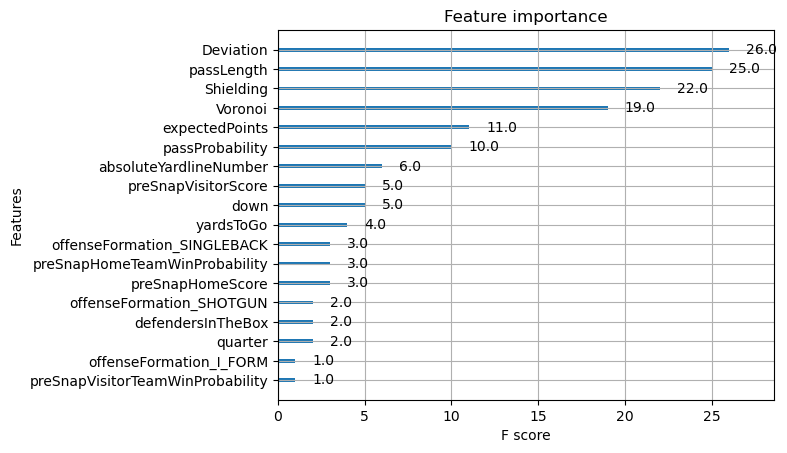

In [50]:
from xgboost import plot_importance

print(clf.best_estimator_)

plot_importance(clf.best_estimator_)
plt.show()

